In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import pickle

#  oversampling 
from imblearn.over_sampling import SMOTE

## Load Dataste

In [3]:
df = pd.read_csv('../data/cleaned_data/final_data.csv')
df.head()

,brands,product_name,categories,countries,food_groups_tags,food_groups,ingredients_text,category_name,country,processed_ingredients,health_label,filtered_food_groups
0,"Mutti,POLPA",pulpe de tomates,"Pflanzliche Lebensmittel und Getränke,Pflanzli...","Australien,Österreich,Belgien,Kanada,Frankreic...","['en:fruits-and-vegetables', 'en:vegetables']",en:vegetables,"tomatoes 99.8%, salt",Plant-based foods and beverages,canada,"tomatoes 99.8%, salt",healthy,vegetables
1,"Maïzena, Unilever",Maizena Fleur de Maïs Sans Gluten 400g,"Plant-based foods and beverages, Plant-based f...","Belgique, Canada, France, Martinique, La Réuni...","['en:cereals-and-potatoes', 'en:cereals']",en:cereals,Amidon de maïs.,Plant-based foods and beverages,canada,amidon de maïs.,healthy,cereals
2,Barilla,Lasagne all'uovo,"Cibi e bevande a base vegetale, Cibi a base ve...","Belgium,Canada,Croatia,France,Germany,Greece,H...","['en:cereals-and-potatoes', 'en:cereals']",en:cereals,"Semola di grano duro, uova fresche di categori...",Plant-based foods and beverages,canada,"semola di grano duro, uova fresche di categori...",healthy,cereals
3,Tipiak,Fine chapelure de pain,"Aliments et boissons à base de végétaux,Alimen...","Canada,France","['en:cereals-and-potatoes', 'en:bread']",en:bread,"Farine de blé (gluten), sel, levure, Traces po...",Plant-based foods and beverages,canada,"farine de blé (gluten), sel, levure, traces po...",healthy,bread
4,"Zespri,Sungold,Catania,ALDI Zespri",Kiwi Sungold,"Aliments et boissons à base de végétaux,Alimen...","Belgique,Canada,France,Allemagne,Pologne,Espag...","['en:fruits-and-vegetables', 'en:fruits']",en:fruits,Kiwifruit,Plant-based foods and beverages,canada,kiwifruit,healthy,fruits


### Model Preparation

In [5]:
df['health_label'] = df['health_label'].map({'healthy':0,'unhealthy':1})

In [6]:
X = df['processed_ingredients']
y= df['health_label']


#### Baseline Accuracy


In [8]:
y.value_counts(normalize = True)# unbalance class so we need to stratify

health_label
0    0.931846
1    0.068154
Name: proportion, dtype: float64

#### Train test split

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

### Logistic Regression

In [12]:
logr_pipeline = Pipeline(
    [
        ('cvec',CountVectorizer()),

        ('smote', SMOTE(random_state=42)),     # Oversampling step
        ('logr',LogisticRegression(random_state=42,max_iter=500))
]
)
grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85, 1.0],      # Ignore very frequent words
    'cvec__min_df': [1, 2, 5],              # Ignore very infrequent words
    'cvec__max_features': [None, 1000,5000, 10000],  # Limit on the number of features

    'logr__C': [0.01, 0.1, 1.0, 10],        # Regularization strength
    'logr__penalty': ['l2'],                # L2 regularization (Ridge)
    'logr__solver': ['lbfgs', 'liblinear']  # Solvers suitable for small datasets
}

gs_logr = GridSearchCV(logr_pipeline,param_grid=grid_params,n_jobs=-1)
gs_logr.fit(X_train,y_train)
print(f' Best parameters:{gs_logr.best_params_}')
print(f' Best score:{gs_logr.best_score_}')

 Best parameters:{'cvec__max_df': 0.75, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'logr__C': 1.0, 'logr__penalty': 'l2', 'logr__solver': 'liblinear'}
 Best score:0.9762206447292637


In [13]:
gs_logr.best_estimator_.named_steps['logr'].intercept_
gs_logr.best_estimator_.named_steps['logr'].coef_

array([[-0.25793994, -0.00141734, -0.19012193, ..., -0.45225083,
        -0.44837071, -0.44837071]])

In [14]:

#Logistic Regression Coefficients 
print(f"Logistic Regression Intercept: {gs_logr.best_estimator_.named_steps['logr'].intercept_}")
print(f"Logistic Regression Coefficients: {gs_logr.best_estimator_.named_steps['logr'].coef_}")
coefficients=gs_logr.best_estimator_.named_steps['logr'].coef_.ravel()
vectorizer = gs_logr.best_estimator_.named_steps['cvec']
feature_names = vectorizer.get_feature_names_out()
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df.head(),coefficients_df.tail(),
top_features = coefficients_df.head()
bottom_features = coefficients_df.tail()


print(f"Top 5 positive coefficients:\n{top_features}")
print(f"Top 5 negative coefficients:\n{bottom_features}")

Logistic Regression Intercept: [-0.46958167]
Logistic Regression Coefficients: [[-0.25793994 -0.00141734 -0.19012193 ... -0.45225083 -0.44837071
  -0.44837071]]
Top 5 positive coefficients:
                   Feature  Coefficient
808            carrageenan     6.342006
562                    bht     4.141269
763          caramel color     3.492931
4268             sucralose     2.685926
2814  monosodium glutamate     2.612977
Top 5 negative coefficients:
            Feature  Coefficient
4792  water natural    -2.625741
4211    stabilisers    -2.745445
4343     sugar salt    -2.783338
7               100    -2.783535
2757        mineral    -2.895137


In [15]:
preds = gs_logr.predict(X_test)

logr_train_accuracy = round(gs_logr.score(X_train, y_train), 2)
logr_test_accuracy = round(gs_logr.score(X_test, y_test), 2)

logr_train_misclassification_rate = round(1 - logr_train_accuracy, 2)
logr_test_misclassification_rate = round(1 - logr_test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {logr_train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {logr_test_accuracy}')

print(f'Training Misclassification Rate: {logr_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {logr_test_misclassification_rate}')
#specificity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

logr_spec = tn / (tn + fp)
print(f'Logistic Regression specificity: {round(logr_spec,2)}')
# recall

logr_recall = tp / (tp + fn)

print(f'Logistic Regression recall: {round(logr_recall,2)}')
logr_f1_not_healthy = f1_score(y_test, preds, pos_label=1)
logr_f1_healthy = f1_score(y_test, preds, pos_label=0)

print(f'Logistic Regression F1_score unhealthy: {round(logr_f1_healthy,2)}')
print(f'Logistic Regression F1_score healthy : {round(logr_f1_not_healthy,2)}')

Training Accuracy of Logistic Regression with Count Vectorizer: 0.99
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.98
Training Misclassification Rate: 0.01
Testing Misclassification Rate: 0.02
Logistic Regression specificity: 0.99
Logistic Regression recall: 0.92
Logistic Regression F1_score unhealthy: 0.99
Logistic Regression F1_score healthy : 0.88


In [16]:
#classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5931
           1       0.85      0.92      0.88       434

    accuracy                           0.98      6365
   macro avg       0.92      0.95      0.94      6365
weighted avg       0.98      0.98      0.98      6365



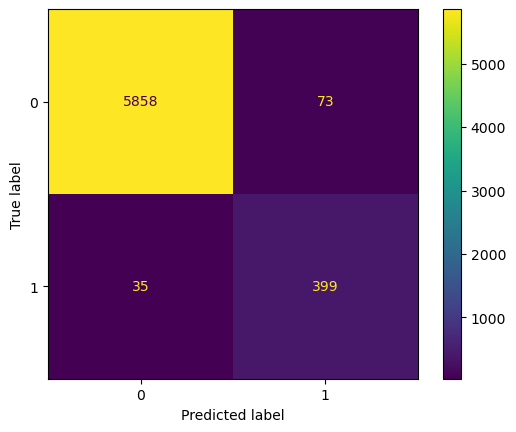

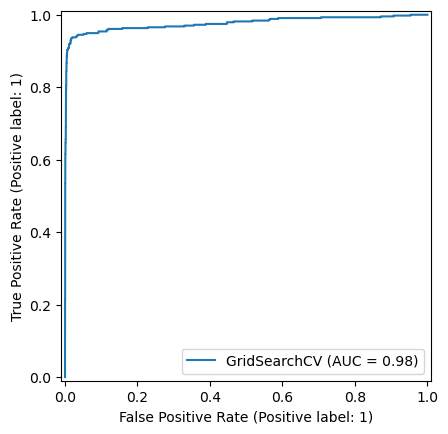

In [17]:
ConfusionMatrixDisplay.from_estimator(gs_logr,X_test,y_test);
RocCurveDisplay.from_estimator(gs_logr,X_test,y_test);

The Logistic Regression model with Count Vectorizer performs well overall. It has a training accuracy of 99% and a testing accuracy of 98%, showing it generalizes well to new data. The misclassification rates are low, with 1% for training and 2% for testing, indicating minimal overfitting. The model is excellent at identifying 'Not Healthy' products, with a specificity of 99%, and it also detects 92% of 'Healthy' products (recall). The F1-score for the 'Healthy' class is very high at 0.99, showing great balance between precision and recall, while the F1-score for 'Not Healthy' is slightly lower at 0.88. This suggests the model could improve slightly in handling the majority class. Overall, it’s a strong model, but addressing class imbalance further might improve its performance for the 'Not Healthy' class.

### Naive Base Classifier

In [20]:
pipe_nb =Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('smote', SMOTE(random_state=42)), #for class imbalance
        ('nb',MultinomialNB())
    ]
)


grid_params = {
    'tf-idf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'nb__alpha': [0.1, 0.5, 1.0]            # Smoothing parameter for Naive Bayes
   
}

gs_nb = GridSearchCV(pipe_nb, grid_params, n_jobs=-1, cv=5)
gs_nb.fit(X_train, y_train)

print(f' Best parameters:{gs_nb.best_params_}')
print(f' Best score:{gs_nb.best_score_}')

 Best parameters:{'nb__alpha': 0.1, 'tf-idf__max_df': 0.9, 'tf-idf__max_features': 4000, 'tf-idf__min_df': 4, 'tf-idf__ngram_range': (1, 2), 'tf-idf__stop_words': 'english'}
 Best score:0.822648344667992


In [21]:
pred_nb = gs_nb.predict(X_test)

nb_train_accuracy = round(gs_nb.score(X_train, y_train), 2)
nb_test_accuracy = round(gs_nb.score(X_test, y_test), 2)

nb_train_misclassification_rate = round(1 - nb_train_accuracy, 2)
nb_test_misclassification_rate = round(1 - nb_test_accuracy, 2)

print(f'Training Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_train_accuracy}')
print(f'Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_test_accuracy}')

print(f'Training Misclassification Rate: {nb_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {nb_test_misclassification_rate}')
#  cross-validation 
cross_val_scores = cross_val_score(gs_nb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)

#  mean cross-validation score
mean_cross_val_score = cross_val_scores.mean()
print(f'cross val score of Naive Bayes :{mean_cross_val_score}')

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred_nb).ravel()

nb_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(nb_spec,2)}')
# recall

nb_recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(nb_recall,2)}')
nb_f1_not_healthy = f1_score(y_test, pred_nb, pos_label=1)
nb_f1_healthy = f1_score(y_test, pred_nb, pos_label=0)


print(f'Naive bayes F1_score not healthy: {round(nb_f1_not_healthy,2)}')
print(f'Naive bayes  F1_score healthy : {round(nb_f1_healthy,2)}')

Training Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.83
Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.83
Training Misclassification Rate: 0.17
Testing Misclassification Rate: 0.17
cross val score of Naive Bayes :0.822648344667992
Naive Bayes specificity: 0.82
Naive Bayes recall: 0.93
Naive bayes F1_score not healthy: 0.42
Naive bayes  F1_score healthy : 0.9


In [22]:
#classification report
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      5931
           1       0.27      0.93      0.42       434

    accuracy                           0.83      6365
   macro avg       0.63      0.88      0.66      6365
weighted avg       0.94      0.83      0.87      6365



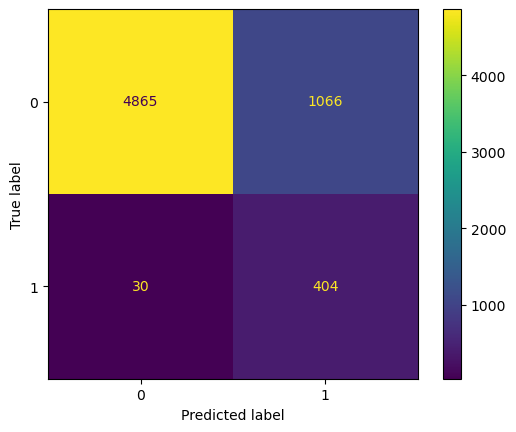

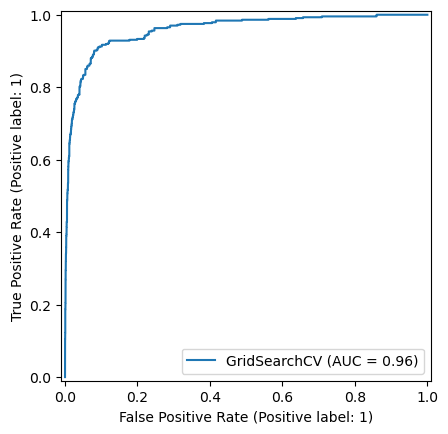

In [23]:
ConfusionMatrixDisplay.from_estimator(gs_nb,X_test,y_test);
RocCurveDisplay.from_estimator(gs_nb,X_test,y_test);

The Naive Bayes model with TF-IDF Vectorizer shows consistent performance between training and testing datasets, with both accuracies at 83% and misclassification rates at 17%. The cross-validation score of approximately 82.26% indicates that the model's performance is stable across different data subsets. The specificity of 82% suggests that the model correctly identifies 82% of 'Not Healthy' instances, while the recall of 93% indicates it successfully detects 93% of 'Healthy' instances. However, there's a notable disparity in the F1-scores: 0.42 for 'Not Healthy' and 0.90 for 'Healthy'. This imbalance suggests that the model is more effective at identifying 'Healthy' products but struggles with accurately classifying 'Not Healthy' ones. To address this,we need to explore alternative algorithms to improve the model's ability to correctly classify both categories.

## Gradient Boosting 

In [26]:
## Gradient Boosting to takle class imbalance

pipe_gb = Pipeline(
    [
        ('tfidf', TfidfVectorizer()),  
        ('gb', GradientBoostingClassifier(random_state=42))  
    ]
)

#  hyperparameter grid
gb_best_params = {
    'gb__n_estimators': [10, 100],       # Number of trees
    'gb__max_depth': [None, 1, 2, 3],   # Depth of trees
    'gb__learning_rate': [0.1, 1, 10],  # Learning rate
}


gs = GridSearchCV(pipe_gb, param_grid=gb_best_params, cv=5, n_jobs=-1, scoring='accuracy')

# 
gs.fit(X_train, y_train)

# best parameters and score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)

Best Parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': None, 'gb__n_estimators': 100}
Best Score: 0.9876912890813226


In [27]:
pred_gb = gs.predict(X_test)

gb_train_accuracy = round(gs.score(X_train, y_train), 2)
gb_test_accuracy = round(gs.score(X_test, y_test), 2)

gb_train_misclassification_rate = round(1 - gb_train_accuracy, 2)
gb_test_misclassification_rate = round(1 - gb_test_accuracy, 2)

print(f'Training Accuracy of Graidient Boosting  with TF-IDF Vectorizer: {gb_train_accuracy}')
print(f'Testing Accuracy of Graidient Boosting  with TF-IDF Vectorizer: {gb_test_accuracy}')

print(f'Training Misclassification Rate: {gb_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {gb_test_misclassification_rate}')
# cross-validation
cross_val_scores = cross_val_score(gs.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)

#  mean cross-validation score
mean_cross_val_score = cross_val_scores.mean()
print(f'cross val score of Graidient Boosting :{mean_cross_val_score}')

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred_gb).ravel()

gb_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(gb_spec,2)}')
# recall

gb_recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(gb_recall,2)}')
gb_f1_not_healthy= f1_score(y_test, pred_gb, pos_label=1)
gb_f1_healthy = f1_score(y_test, pred_gb, pos_label=0)


print(f'Graidient Boosting F1_score not healthy: {round(gb_f1_not_healthy,2)}')
print(f'Graidient Boosting  F1_score healthy : {round(gb_f1_healthy,2)}')

Training Accuracy of Graidient Boosting  with TF-IDF Vectorizer: 1.0
Testing Accuracy of Graidient Boosting  with TF-IDF Vectorizer: 0.99
Training Misclassification Rate: 0.0
Testing Misclassification Rate: 0.01
cross val score of Graidient Boosting :0.9876912890813226
Naive Bayes specificity: 1.0
Naive Bayes recall: 0.93
Graidient Boosting F1_score not healthy: 0.95
Graidient Boosting  F1_score healthy : 1.0


In [28]:
#classification report
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5931
           1       0.96      0.93      0.95       434

    accuracy                           0.99      6365
   macro avg       0.98      0.96      0.97      6365
weighted avg       0.99      0.99      0.99      6365



In [ ]:
ConfusionMatrixDisplay.from_estimator(gs,X_test,y_test);
RocCurveDisplay.from_estimator(gs,X_test,y_test);

The Gradient Boosting model with TF-IDF Vectorizer exhibits exceptional performance. It achieves perfect training accuracy (100%) and near-perfect testing accuracy (99%), indicating excellent generalization to new data. The misclassification rates are minimal, with 0% for training and 1% for testing, suggesting the model makes very few errors. A cross-validation score of approximately 98.77% confirms the model's robustness across different data subsets.

The model demonstrates outstanding capability in identifying 'Not Healthy' products, achieving a specificity of 100%, meaning it correctly classifies all' Not Healthy' instances. It also effectively detects 'Healthy' products, with a recall of 93%, indicating it successfully identifies 93% of 'Healthy' instances. The F1-scores are impressive: 0.95 for 'Not Healthy' and 1.0 for 'Healthy', reflecting a strong balance between precision and recall for both classes.

Overall, the Gradient Boosting model with TF-IDF Vectorizer is highly accurate and reliable in classifying both 'Healthy' and 'Not Healthy' products, making it a robust choice for this classification task.

In [ ]:
#save the best model which is gradient boosting
with open('../models/foodclassifier.pkl', 'wb') as pickle_out:
    pickle.dump(gs.best_estimator_, pickle_out)


In [ ]:
if gs.best_estimator_ is None:
    raise ValueError("❌ Error: `gs.best_estimator_` is None! Model training might have failed.")
